In [3]:
from datetime import datetime, timedelta
from workalendar.europe import Netherlands
import gc
import random
import pandas as pd
import sys
import numpy as np

In [5]:
merged_data = pd.read_csv("merged_dfs.csv")

In [7]:
merged_data = merged_data.head(100) # Filter for a smaller df
merged_data = merged_data.drop('Unnamed: 0', axis=1)
merged_data

,RND_ID,2023-01-01 00:00,2023-01-01 00:15,2023-01-01 00:30,2023-01-01 00:45,2023-01-01 01:00,2023-01-01 01:15,2023-01-01 01:30,2023-01-01 01:45,2023-01-01 02:00,...,2023-12-31 22:00,2023-12-31 22:15,2023-12-31 22:30,2023-12-31 22:45,2023-12-31 23:00,2023-12-31 23:15,2023-12-31 23:30,2023-12-31 23:45,BASELOAD_PROFILE,CONNECTION_CATEGORY
0,8423,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,010,AC4A
1,6756,36.0,32.0,32.0,36.0,32.0,36.0,32.0,36.0,32.0,...,34.09,33.31,30.57,29.65,32.06,29.13,28.25,27.85,E3B,AC4B
2,1077,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,...,1.50,2.00,1.50,1.50,2.00,1.50,2.00,1.50,008,AC4A
3,8061,16.0,8.0,12.0,8.0,12.0,16.0,12.0,12.0,12.0,...,8.80,11.00,10.19,9.19,8.80,9.00,11.00,12.40,001,AC4B
4,10575,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,...,3.54,1.15,1.10,1.10,1.10,1.10,1.10,1.12,008,AC4B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11466,16.0,16.0,16.0,12.0,16.0,16.0,16.0,12.0,16.0,...,7.79,8.09,8.09,8.09,6.90,6.59,6.90,6.90,018,AC4A
96,810,12.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,2.39,2.39,2.39,2.39,2.10,2.39,2.39,2.39,E3C,AC4B
97,12125,16.0,16.0,16.0,16.0,20.0,16.0,20.0,20.0,16.0,...,14.00,13.35,14.24,19.64,13.32,13.03,14.19,14.96,008,AC4B
98,2901,12.0,8.0,4.0,4.0,4.0,4.0,4.0,0.0,4.0,...,2.70,2.70,2.44,2.35,2.39,2.24,2.75,2.89,E3C,AC4A


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from workalendar.europe import Netherlands

def is_workday(date):
    """
    Check if the date is a workday (Monday to Friday).
    """
    return date.weekday() < 5

def is_working_hours(time):
    """
    Check if the time is within working hours (9:00 to 17:00).
    """
    return 9 <= time.hour < 17

def is_not_holiday(date, holidays):
    """
    Check if the given date is not a holiday.
    """
    return date not in holidays

def get_dutch_holidays(year):
    """
    Get Dutch holidays for a specified year.
    """
    cal = Netherlands()
    return {date: name for date, name in cal.holidays(year)}

def generate_time_slots(start_date, end_date, interval='15min'):
    """
    Generate time slots between two dates at a specified interval.
    """
    return pd.date_range(start=start_date, end=end_date, freq=interval)

# Initialize Dutch calendar
def get_low_high_tariff():
    cal = Netherlands()
    # Get holidays for a specific year
    year = 2023
    nl_holidays_2023 = cal.holidays(year)

    # Define start and end date
    start_date = datetime(2023, 1, 1, 0, 0)
    end_date = datetime(2023, 12, 31, 23, 45)

    # Initialize list to store timestamps
    timestamps = []

    # Generate timestamps with 15-minute intervals
    current_date = start_date
    while current_date <= end_date:
        timestamps.append(current_date)
        current_date += timedelta(minutes=15)

    # Generate the binary sequence
    high_tariff = []
    for timestamp in timestamps:
        if is_workday(timestamp) and is_working_hours(timestamp.time()) and is_not_holiday(timestamp, nl_holidays_2023):
            high_tariff.append(1)
        else:
            high_tariff.append(0)
    return high_tariff, timestamps

# Get the high/low tariff and timestamps
high_tariff, timestamps = get_low_high_tariff()

# Convert timestamps to match the format in the dataset
timestamp_str = [ts.strftime('%Y-%m-%d %H:%M') for ts in timestamps]

# Create a DataFrame with the new features
tariff_df = pd.DataFrame({
    'Timestamp': timestamp_str,
    'High_Tariff': high_tariff
})
tariff_df['Timestamp'] = pd.to_datetime(tariff_df['Timestamp'])

In [9]:
# Extract date-time columns and RND_ID, Baseload_profile, Connection category columns
date_time_cols = [col for col in merged_data.columns if '2023' in col]
id_cols = [col for col in merged_data.columns if col not in date_time_cols]

# Convert date-time columns to long format
merged_data = merged_data.melt(id_vars=id_cols, value_vars=date_time_cols, var_name='Timestamp', value_name='Consumption')

# Convert 'Timestamp' to string to ensure format consistency
merged_data['Timestamp'] = merged_data['Timestamp'].astype(str)

In [10]:
# Convert 'Timestamp' to datetime
merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp'])

# Merge tariff information with the main data
merged_data = pd.merge(merged_data, tariff_df, on='Timestamp', how='left')

In [11]:
# Add time-based features
merged_data['hour'] = merged_data['Timestamp'].dt.hour
merged_data['day_of_week'] = merged_data['Timestamp'].dt.dayofweek
merged_data['month'] = merged_data['Timestamp'].dt.month
merged_data['is_weekend'] = merged_data['day_of_week'] >= 5

# Compute monthly total and average consumption
monthly_total = merged_data.groupby(['RND_ID', 'month'])['Consumption'].sum().reset_index()
monthly_avg = merged_data.groupby(['RND_ID', 'month'])['Consumption'].mean().reset_index()

# Merge monthly total and average back to the main data
merged_data = pd.merge(merged_data, monthly_total, on=['RND_ID', 'month'], suffixes=('', '_monthly_total'))
merged_data = pd.merge(merged_data, monthly_avg, on=['RND_ID', 'month'], suffixes=('', '_monthly_avg'))

In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504000 entries, 0 to 3503999
Data columns (total 12 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   RND_ID                     int64         
 1   BASELOAD_PROFILE           object        
 2   CONNECTION_CATEGORY        object        
 3   Timestamp                  datetime64[ns]
 4   Consumption                float64       
 5   High_Tariff                int64         
 6   hour                       int32         
 7   day_of_week                int32         
 8   month                      int32         
 9   is_weekend                 bool          
 10  Consumption_monthly_total  float64       
 11  Consumption_monthly_avg    float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int32(3), int64(2), object(2)
memory usage: 257.3+ MB


# Creat lagged features for 15min, 30min, 45 minutes and 1 hour and historical statistics features (mean, median, std)

In [ ]:
merged_df = pd.DataFrame(data)
merged_df.set_index('Timestamp', inplace=True)

# Define the number of periods for each lag
lag_periods = {
    '15_minutes': 1,
    '30_minutes': 2,
    '45_minutes': 3,
    '1_hour': 4
}

# Create lagged features for 'Consumption'
for label, periods in lag_periods.items():
    merged_df[f'Consumption_lag_{label}'] = merged_df.groupby('RND_ID')['Consumption'].shift(periods)

# Create rolling statistics features
def create_rolling_features(df, column, windows, groupby_col='RND_ID'):
    for window in windows:
        window_size = window['size']
        window_label = window['label']
        rolling_obj = df.groupby(groupby_col)[column].rolling(window=window_size, min_periods=1)
        df[f'{column}_mean_{window_label}'] = rolling_obj.mean().reset_index(level=0, drop=True)
        df[f'{column}_median_{window_label}'] = rolling_obj.median().reset_index(level=0, drop=True)
        df[f'{column}_std_{window_label}'] = rolling_obj.std().reset_index(level=0, drop=True)

# Define the windows for rolling statistics
windows = [
    {'size': 1, 'label': '15_minutes'},
    {'size': 2, 'label': '30_minutes'},
    {'size': 3, 'label': '45_minutes'},
    {'size': 4, 'label': '1_hour'}
]

# Apply the function to create rolling features
create_rolling_features(merged_df, 'Consumption', windows)

# Display the resulting DataFrame
print(merged_df.head(10))

In [15]:
#merged_df = pd.DataFrame(merged_data)
merged_data.set_index('Timestamp', inplace=True)

# Create lagged features
lags = [15, 30, 45, 60]  # in minutes
for lag in lags:
    merged_data[f'Consumption_lag_{lag}min'] = merged_data['Consumption'].shift(lag // 15)

# Create historical statistics features
window = 4  # You can adjust the window size as needed (e.g., 4 for the past hour if data is in 15-min intervals)
merged_data['Consumption_rolling_mean'] = merged_data['Consumption'].rolling(window=window).mean()
merged_data['Consumption_rolling_median'] = merged_data['Consumption'].rolling(window=window).median()
merged_data['Consumption_rolling_std'] = merged_data['Consumption'].rolling(window=window).std()

# Display the DataFrame with new features
print(merged_data.head(10))

                     RND_ID BASELOAD_PROFILE CONNECTION_CATEGORY  Consumption  \
Timestamp                                                                       
2023-01-01 00:00:00    8423              010                AC4A          0.0   
2023-01-01 00:15:00    8423              010                AC4A          0.0   
2023-01-01 00:30:00    8423              010                AC4A          0.0   
2023-01-01 00:45:00    8423              010                AC4A          0.0   
2023-01-01 01:00:00    8423              010                AC4A          4.0   
2023-01-01 01:15:00    8423              010                AC4A          0.0   
2023-01-01 01:30:00    8423              010                AC4A          0.0   
2023-01-01 01:45:00    8423              010                AC4A          0.0   
2023-01-01 02:00:00    8423              010                AC4A          4.0   
2023-01-01 02:15:00    8423              010                AC4A          0.0   

                     High_T

In [16]:
merged_data.to_csv

,RND_ID,BASELOAD_PROFILE,CONNECTION_CATEGORY,Consumption,High_Tariff,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,Consumption_lag_15min,Consumption_lag_30min,Consumption_lag_45min,Consumption_lag_60min,Consumption_rolling_mean,Consumption_rolling_median,Consumption_rolling_std
Timestamp,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,8423,010,AC4A,0.00,0,0,6,1,True,23104.00,7.763441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:15:00,8423,010,AC4A,0.00,0,0,6,1,True,23104.00,7.763441,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:30:00,8423,010,AC4A,0.00,0,0,6,1,True,23104.00,7.763441,0.00,0.00,NaN,NaN,NaN,NaN,NaN
2023-01-01 00:45:00,8423,010,AC4A,0.00,0,0,6,1,True,23104.00,7.763441,0.00,0.00,0.00,NaN,0.0000,0.00,0.000000
2023-01-01 01:00:00,8423,010,AC4A,4.00,0,1,6,1,True,23104.00,7.763441,0.00,0.00,0.00,0.00,1.0000,0.00,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00,4109,E3A,AC4B,7.51,0,22,6,12,True,21328.84,7.166949,7.32,7.44,7.12,7.48,7.3475,7.38,0.170758
2023-12-31 23:00:00,4109,E3A,AC4B,7.20,0,23,6,12,True,21328.84,7.166949,7.51,7.32,7.44,7.12,7.3675,7.38,0.136473
2023-12-31 23:15:00,4109,E3A,AC4B,7.28,0,23,6,12,True,21328.84,7.166949,7.20,7.51,7.32,7.44,7.3275,7.30,0.131498


In [17]:
merged_data.to_csv("100_customers_featured_telemetry.csv")

 # Fourier Transform fature Montly Aggregated 

### The Fourier Transform is a mathematical technique that transforms time-domain data into the frequency domain, providing insights into the periodicity and frequency components of the data. By applying the Fourier Transform to monthly consumption data, we can capture and utilize underlying periodic patterns in the data,

- Seasonality and Trends: The Fourier Transform can help capture seasonality and trends in the data, which are important for forecasting.
- Aggregation Method: The choice of aggregation (sum, mean, etc.) can affect the FFT results. Choose based on the specific characteristics of your data.
- Merge Strategy: Ensure the merge strategy aligns with your data's structure and the analysis requirements.
This approach will help you incorporate Fourier Transform features into your dataset, potentially improving the predictive power of your model by capturing periodic patterns in the consumption data.

In [ ]:
merged_data=

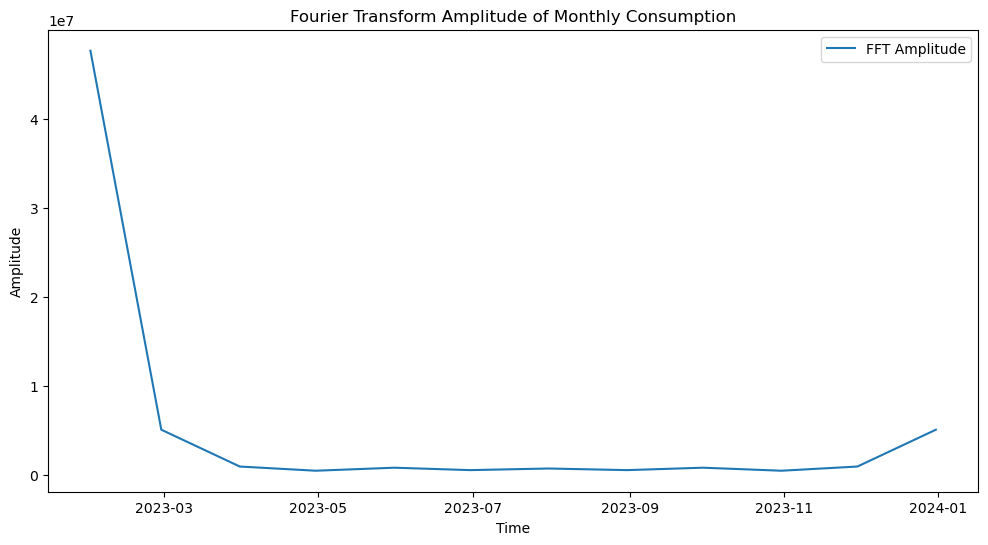

   RND_ID BASELOAD_PROFILE CONNECTION_CATEGORY  Consumption  High_Tariff  \
0    8423              010                AC4A          0.0            0   
1    8423              010                AC4A          0.0            0   
2    8423              010                AC4A          0.0            0   
3    8423              010                AC4A          0.0            0   
4    8423              010                AC4A          4.0            0   
5    8423              010                AC4A          0.0            0   
6    8423              010                AC4A          0.0            0   
7    8423              010                AC4A          0.0            0   
8    8423              010                AC4A          4.0            0   
9    8423              010                AC4A          0.0            0   

   hour  day_of_week  is_weekend  Consumption_monthly_total  \
0     0            6        True                    23104.0   
1     0            6        True     

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Aggregate data by month
monthly_consumption = merged_data['Consumption'].resample('M').sum()

# Apply Fourier Transform
fft_result = np.fft.fft(monthly_consumption)
fft_frequencies = np.fft.fftfreq(len(monthly_consumption))

# Extract amplitude and phase
amplitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Create a DataFrame for Fourier features
fft_features = pd.DataFrame({
    'FFT_Amplitude': amplitude,
    'FFT_Phase': phase
}, index=monthly_consumption.index)

# Plot to see the results (optional)
plt.figure(figsize=(12, 6))
plt.plot(monthly_consumption.index, amplitude, label='FFT Amplitude')
plt.title('Fourier Transform Amplitude of Monthly Consumption')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Add a month column for merging
fft_features['month'] = fft_features.index.month
merged_data['month'] = merged_data.index.month

# Merge the features into the original DataFrame
merged_data = pd.merge(merged_data, fft_features, on='month', how='left')

# Drop unnecessary columns if needed
merged_data.drop(['month'], axis=1, inplace=True)

# Display the DataFrame with new Fourier Transform features
print(merged_data.head(10))

In [21]:
merged_data

,RND_ID,BASELOAD_PROFILE,CONNECTION_CATEGORY,Consumption,High_Tariff,hour,day_of_week,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,Consumption_lag_15min,Consumption_lag_30min,Consumption_lag_45min,Consumption_lag_60min,Consumption_rolling_mean,Consumption_rolling_median,Consumption_rolling_std,FFT_Amplitude,FFT_Phase
0,8423,010,AC4A,0.00,0,0,6,True,23104.00,7.763441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.760066e+07,0.00000
1,8423,010,AC4A,0.00,0,0,6,True,23104.00,7.763441,0.00,NaN,NaN,NaN,NaN,NaN,NaN,4.760066e+07,0.00000
2,8423,010,AC4A,0.00,0,0,6,True,23104.00,7.763441,0.00,0.00,NaN,NaN,NaN,NaN,NaN,4.760066e+07,0.00000
3,8423,010,AC4A,0.00,0,0,6,True,23104.00,7.763441,0.00,0.00,0.00,NaN,0.0000,0.00,0.000000,4.760066e+07,0.00000
4,8423,010,AC4A,4.00,0,1,6,True,23104.00,7.763441,0.00,0.00,0.00,0.00,1.0000,0.00,2.000000,4.760066e+07,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503995,4109,E3A,AC4B,7.51,0,22,6,True,21328.84,7.166949,7.32,7.44,7.12,7.48,7.3475,7.38,0.170758,5.104820e+06,-0.49681
3503996,4109,E3A,AC4B,7.20,0,23,6,True,21328.84,7.166949,7.51,7.32,7.44,7.12,7.3675,7.38,0.136473,5.104820e+06,-0.49681
3503997,4109,E3A,AC4B,7.28,0,23,6,True,21328.84,7.166949,7.20,7.51,7.32,7.44,7.3275,7.30,0.131498,5.104820e+06,-0.49681
3503998,4109,E3A,AC4B,7.48,0,23,6,True,21328.84,7.166949,7.28,7.20,7.51,7.32,7.3675,7.38,0.151300,5.104820e+06,-0.49681


In [22]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504000 entries, 0 to 3503999
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   RND_ID                      int64  
 1   BASELOAD_PROFILE            object 
 2   CONNECTION_CATEGORY         object 
 3   Consumption                 float64
 4   High_Tariff                 int64  
 5   hour                        int32  
 6   day_of_week                 int32  
 7   is_weekend                  bool   
 8   Consumption_monthly_total   float64
 9   Consumption_monthly_avg     float64
 10  Consumption_lag_15min       float64
 11  Consumption_lag_30min       float64
 12  Consumption_lag_45min       float64
 13  Consumption_lag_60min       float64
 14  Consumption_rolling_mean    float64
 15  Consumption_rolling_median  float64
 16  Consumption_rolling_std     float64
 17  FFT_Amplitude               float64
 18  FFT_Phase                   float64
dtypes: bool(1), float64(1